In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
load_dir = 'C:/Users/User/Face_Recognization_FT'


# Load the categories and datasets from pickle files
pickle_in = open(os.path.join(load_dir, "categories.pickle"), "rb")
categories = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "X_train.pickle"), "rb")
X_train = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "y_train.pickle"), "rb")
y_train = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "X_valid.pickle"), "rb")
X_valid = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "y_valid.pickle"), "rb")
y_valid = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "X_test.pickle"), "rb")
X_test = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "y_test.pickle"), "rb")
y_test = pickle.load(pickle_in)

In [3]:
# Data Augmentation for training set
datagen = ImageDataGenerator(
    rotation_range=20,  # Reduced rotation range
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
# Model input shape
input_tensor = Input(shape=(256, 256, 3))

# Load MobileNet with pre-trained ImageNet weights, without the top classification layers
base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_tensor)

C:\Users\User\AppData\Local\Temp\ipykernel_23872\904856200.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_tensor)


In [5]:
# Unfreeze the last 20 layers of MobileNet for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce spatial dimensions
x = Dropout(0.8)(x)  # Increased dropout rate to reduce overfitting
x = Dense(256, activation='relu')(x)  # Dense layer with 256 units and ReLU activation
x = Dropout(0.2)(x)  # Additional dropout layer
predictions = Dense(32, activation='softmax')(x)  

In [6]:
# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0004), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and model checkpointing

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_mobilenet_model.keras', monitor='val_accuracy', save_best_only=True)


In [7]:
# Define the number of epochs
EPOCHS = 20  # Increased number of epochs

# Fit the model using the data generator for augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Using data augmentation
    validation_data=(X_valid, y_valid),  # Validation data
    epochs=EPOCHS,  # Number of epochs
    verbose=1,  # Display progress during training
    callbacks=[early_stopping, model_checkpoint]  # Use callbacks
)

C:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


C:\Users\User\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 881ms/step - accuracy: 0.5065 - loss: 2.6012 - val_accuracy: 0.6667 - val_loss: 1.8309
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 841ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.6736 - val_loss: 1.1299
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 846ms/step - accuracy: 0.9986 - loss: 0.0081 - val_accuracy: 0.8611 - val_loss: 0.3038
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 848ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0286
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 842ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 2.8690e-04
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 1.0000 - loss: 8.2900e-04 - val_accuracy: 1.0000 - val_loss: 3.3417e-05
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 1.0000 - loss: 1.6644e-04 - val_accuracy

In [8]:
loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 1.0000 - loss: 0.0261
Validation Loss: 0.028584113344550133
Validation Accuracy: 1.0


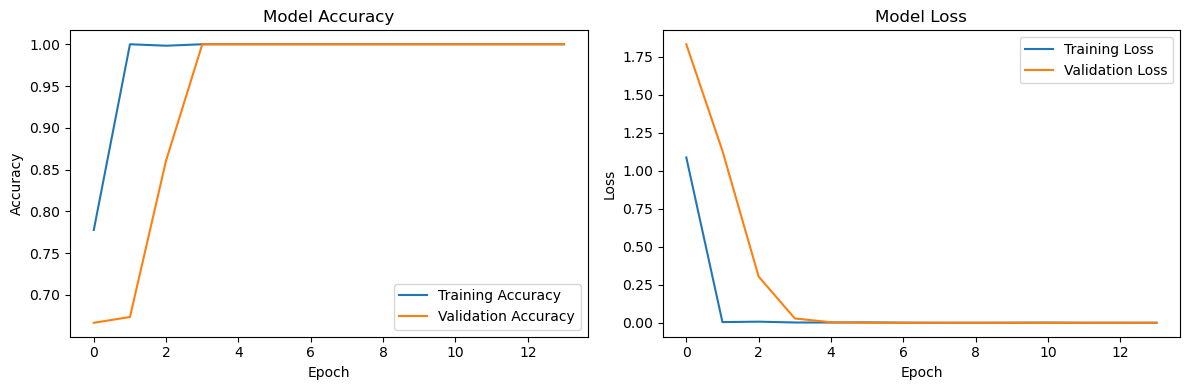

In [9]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [10]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.9857 - loss: 0.0442
Test Loss: 0.03636484593153
Test Accuracy: 0.9888888597488403


In [11]:
predictions = model.predict(X_test)

C:\Users\User\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 256, 256, 3))
  warnings.warn(msg)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step


In [15]:
model_path = 'C:/Users/User/Face_Recognization_FT'

model.save(os.path.join(model_path, "testv1.h5"))